In [104]:
import cpmpy as cp
import numpy as np
np.random.seed(0)

from numpy.random import randint, random

In [105]:
n_task = 100
n_teams = 8

# generate parameters for tasks
durations = randint(5,25, size=n_task)

# not all teams can do the same set of tasks
team_compat = [set(randint(0,n_teams,size=n_teams)) for _ in range(n_task)]

# generate precedences
# this can actually generate a cycle of precedences, but let's hope it does not...
before = [randint(0,n_task) if random() > 0.5 else None for _ in range(n_task)]

for t in range(n_task):
    print(f"Task {t} can be performed by any of {team_compat[t]}")

Task 0 can be performed by any of {0, 1, 2, 5, 7}
Task 1 can be performed by any of {1, 2, 3, 7}
Task 2 can be performed by any of {2, 3, 6}
Task 3 can be performed by any of {1, 2, 3, 4, 6}
Task 4 can be performed by any of {0, 1, 2, 3, 4, 6}
Task 5 can be performed by any of {0, 3, 6}
Task 6 can be performed by any of {0, 2, 3, 4, 5, 6}
Task 7 can be performed by any of {0, 2, 3, 5, 6}
Task 8 can be performed by any of {0, 2, 3, 7}
Task 9 can be performed by any of {0, 3, 4, 5, 6}
Task 10 can be performed by any of {1, 3, 4, 5, 6}
Task 11 can be performed by any of {0, 1, 5, 6}
Task 12 can be performed by any of {0, 1, 3, 4, 5, 6}
Task 13 can be performed by any of {0, 1, 3, 4, 5, 6, 7}
Task 14 can be performed by any of {0, 1, 2, 5, 7}
Task 15 can be performed by any of {1, 3, 5, 6, 7}
Task 16 can be performed by any of {0, 2, 3, 4, 5, 6, 7}
Task 17 can be performed by any of {2, 3, 4, 6, 7}
Task 18 can be performed by any of {0, 3, 4, 5, 7}
Task 19 can be performed by any of {0, 2,

## Creating the model

We use a Boolean matrix `alloc` where `alloc[i,j]` indicates whether task `i` is assigned to team `j`.

The model consists of two main constraint types:
1. Team compatibility, encoded by enforcing the `alloc[i,j]` to `False` for incompatible teams
2. No-overlap constraints between tasks asssigned to the same team. 
 
The latter of these constraints are encoded using optional interval variables.


In [106]:
model = cp.Model()
alloc = cp.boolvar(shape=(n_task, n_teams), name="alloc")

# each task has to be assigned to 1 team
model += [cp.sum(alloc[task,:]) == 1 for task in range(n_task)]

# team compatibility
for task, compatible_teams in enumerate(team_compat):
    incompatible = set(range(n_teams)) - compatible_teams
    model += [alloc[task, team] == False for team in incompatible]

# precedences
start = cp.intvar(0,durations.sum(), shape=n_task)
end = cp.intvar(0, durations.sum(), shape=n_task)

for task, must_before in enumerate(before):
    if must_before is not None:
        model += start[task] >= end[must_before]
        
# non-overlap
for team in range(n_teams):
    team_intervals = cp.directvar("NewOptionalIntervalVar",
                                 (start, durations, end, alloc[:,team]),
                                 insert_name_at_index=4,
                                 shape=n_task,
                                 novar=(1,))
    
    model += cp.DirectConstraint("AddNoOverlap", (team_intervals,))
    
# minimize the makespan
model.minimize(cp.max(end))

In [107]:
model.solve(solver="ortools")

True

In [108]:
import pandas as pd

allocated = np.sum(np.arange(n_teams) * alloc.value(), axis=1)
solution = pd.DataFrame(data=np.array([start.value(), durations, allocated]).T,
                        columns=["Start", "Duration", "Team"])

solution["Task"] = "Task " + solution.index.astype(str)

solution

,Start,Duration,Team,Task
0,20,17,5,Task 0
1,59,20,1,Task 1
2,96,5,2,Task 2
3,28,8,4,Task 3
4,23,8,1,Task 4
...,...,...,...,...
95,167,7,6,Task 95
96,61,21,7,Task 96
97,0,8,4,Task 97
98,18,7,3,Task 98


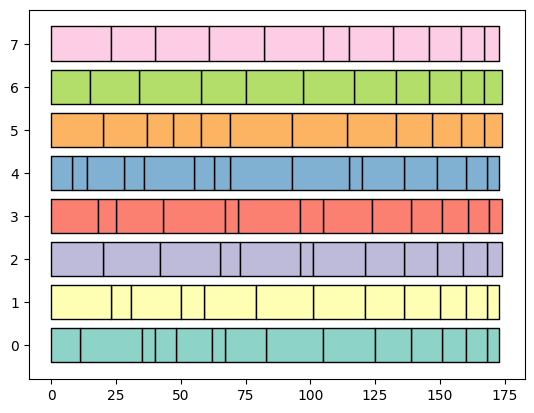

In [109]:
import matplotlib.pyplot as plt

cmap = plt.get_cmap("Set3")

def plot_ghantt(df):
    fig, ax = plt.subplots()
    
    for team in range(n_teams):
        team_tasks = df[df['Team'] == team]
        ax.broken_barh(list(zip(team_tasks["Start"], team_tasks["Duration"])),
                       (team-0.4, 0.8), 
                       facecolors=cmap(team),
                       edgecolor="black")
    
        
    # ax.set_xlim(0, max(df['Start'] + df['Duration']))
plot_ghantt(solution)